In [65]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.rdMolAlign import AlignMol
from rdkit.Chem.rdmolops import RemoveHs

The molecule that will define the fixed piece

In [2]:
ref_buff = """ref_ligand
                    3D
 Schrodinger Suite 2019-4.
 23 23  0  0  1  0            999 V2000
   13.8921   -2.4077   24.1269 C   0  0  0  0  0  0
   13.4897   -0.2702   23.1446 C   0  0  0  0  0  0
   12.8011    1.0351   23.3277 C   0  0  0  0  0  0
   11.6117    1.1475   24.0810 C   0  0  0  0  0  0
   10.9808    2.3973   24.2401 C   0  0  0  0  0  0
   11.5348    3.5418   23.6347 C   0  0  0  0  0  0
   12.7111    3.4432   22.8672 C   0  0  0  0  0  0
   13.3408    2.1928   22.7264 C   0  0  0  0  0  0
    9.4491    5.0959   22.7844 N   0  0  0  0  0  0
   13.2656   -1.1348   24.1544 O   0  0  0  0  0  0
   14.2110   -0.5201   22.1789 O   0  0  0  0  0  0
   11.6894    6.1877   23.4320 O   0  0  0  0  0  0
   10.1931    5.1760   25.2380 O   0  0  0  0  0  0
   10.7644    5.1384   23.8833 S   0  0  0  0  0  0
   13.5601   -3.0220   24.9622 H   0  0  0  0  0  0
   13.6512   -2.9371   23.2047 H   0  0  0  0  0  0
   14.9743   -2.3067   24.1963 H   0  0  0  0  0  0
   11.1706    0.2738   24.5305 H   0  0  0  0  0  0
   10.0785    2.4749   24.8291 H   0  0  0  0  0  0
   13.1467    4.3202   22.4103 H   0  0  0  0  0  0
   14.2657    2.1382   22.1772 H   0  0  0  0  0  0
    8.9928    6.0050   22.7148 H   0  0  0  0  0  0
    8.7689    4.3739   23.0292 H   0  0  0  0  0  0
  1 10  1  0  0  0
  1 15  1  0  0  0
  1 16  1  0  0  0
  1 17  1  0  0  0
  2  3  1  0  0  0
  2 10  1  0  0  0
  2 11  2  0  0  0
  3  4  1  0  0  0
  3  8  2  0  0  0
  4  5  2  0  0  0
  4 18  1  0  0  0
  5  6  1  0  0  0
  5 19  1  0  0  0
  6  7  2  0  0  0
  6 14  1  0  0  0
  7  8  1  0  0  0
  7 20  1  0  0  0
  8 21  1  0  0  0
  9 14  1  0  0  0
  9 22  1  0  0  0
  9 23  1  0  0  0
 12 14  2  0  0  0
 13 14  2  0  0  0
M  END
$$$
"""

In [3]:
ref = Chem.MolFromMolBlock(ref_buff)

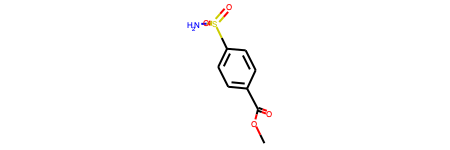

In [4]:
ref

We want to generate conformers for this molecule with ref fixed

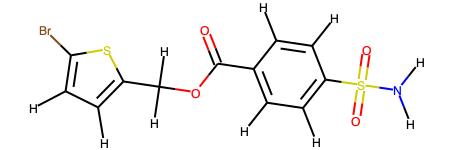

In [68]:
smiles = "NS(=O)(=O)c1ccc(C(=O)OCc2ccc(Br)s2)cc1"
mol = Chem.MolFromSmiles(smiles)
mol = Chem.AddHs(mol)
mol

A simple function to generate conformers with a constrained piece and align the resulting conformers to the reference. 

In [57]:
def generate_aligned_conformers(mol, ref):
    # generate a pattern for matching, not sure if this is necessary
    ref_smi = Chem.MolToSmiles(ref)
    ref_pat = Chem.MolFromSmarts(ref_smi)
    # match mol and ref to the pattern to get atom maps
    ref_map = ref.GetSubstructMatch(ref_pat)
    mol_map = mol.GetSubstructMatch(ref_pat)
    # get the list of coordinates to fix in the conformer generation step
    ref_crd_list = [ref.GetConformer(0).GetAtomPosition(x) for x in ref_map]
    # create a correspondence between the atoms in mol and coordinates
    crd_map = dict(zip(mol_map,ref_crd_list))
    # generate conformers
    AllChem.EmbedMultipleConfs(mol, useExpTorsionAnglePrefs=True, useBasicKnowledge=True, coordMap=crd_map)
    # Align the conformers to ref
    atom_map = list(zip(mol_map,ref_map))
    rms_list = []
    for i in range(0,mol.GetNumConformers()):
        rms_list.append(AlignMol(prbMol=mol,refMol=ref,prbCid=i,refCid=0,atomMap=atom_map))
    return rms_list

In [58]:
generate_aligned_conformers(mol,ref)

[0.9988816655342552,
 0.9989662408217492,
 0.9988195686336423,
 0.17211655452091812,
 0.9988716288575492,
 0.9985922869733387,
 0.9987462730595041,
 0.9987995724128214,
 0.17195403901260475,
 0.9990544187783106]

Note that the resulting conformers have two different orientations for the sulfonamide. 

In [66]:
import py3Dmol 
view = py3Dmol.view() 
for i in range(mol.GetNumConformers()):
    mb = Chem.MolToMolBlock(RemoveHs(mol),confId=i)
    view.addModel(mb,'sdf')
view.setStyle({'stick':{}})
view.setBackgroundColor('0xeeeeee')
view.zoomTo()
view

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Try this again with **ConstrainedEmbed**

In [60]:
mol_2 = Chem.AddHs(Chem.MolFromSmiles(smiles))
newmol = AllChem.ConstrainedEmbed(mol_2,ref)

Looks like this only generated a sing conformer

In [61]:
newmol.GetNumConformers()

1